In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.4 MB/s eta 0:00:00


In [2]:
# Cargar librerías para ejecutar el modelo
import sagemaker
import boto3
import joblib
import pickle
import tarfile
import xgboost as xgb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


from sklearn.preprocessing import StandardScaler
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.tuner import HyperparameterTuner
from sklearn.datasets import dump_svmlight_file

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


# 1. Conexión y Configuración de S3

In [3]:
# Variables para la conexión y configuración de S3
role = get_execution_role()
bucket = 'sagemaker-test-api-bucket20'
data_key = 'proyecto_dir20/synthetic_customer_data.csv'
data_location = f's3://{bucket}/{data_key}'

# 2. Leer los Datos

In [4]:
# Leer los datos desde S3
data = pd.read_csv(data_location)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [5]:
data.head()

,customer_id,age,gender,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment
0,CUST_0001,56,Male,65648,49624.926758,17,467.729972,52.525842,0,235,61,medium_value
1,CUST_0002,69,Male,123537,46357.348299,196,874.799829,11.120875,0,182,48,medium_value
2,CUST_0003,46,Male,145991,27043.860801,175,207.419293,86.816930,0,199,50,medium_value
3,CUST_0004,32,Female,29516,42117.461389,25,131.749484,29.736153,0,356,32,medium_value
4,CUST_0005,60,Male,132863,26095.803066,94,289.081236,16.253799,1,245,29,high_value


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               1000 non-null   object 
 1   age                       1000 non-null   int64  
 2   gender                    1000 non-null   object 
 3   annual_income             1000 non-null   int64  
 4   total_spent               1000 non-null   float64
 5   num_purchases             1000 non-null   int64  
 6   avg_purchase_value        1000 non-null   float64
 7   online_activity_score     1000 non-null   float64
 8   loyalty_program           1000 non-null   int64  
 9   days_since_last_purchase  1000 non-null   int64  
 10  num_site_visits           1000 non-null   int64  
 11  customer_segment          1000 non-null   object 
dtypes: float64(3), int64(6), object(3)
memory usage: 93.9+ KB


In [7]:
# Asegurar coincidencia exacta en todas las subcategorías
data['customer_segment'] = data['customer_segment'].str.lower().str.strip()
print(data['customer_segment'].unique())

# Mapeo manual de las categorías
data['customer_segment'] = data['customer_segment'].map({
    'low_value': 0,
    'medium_value': 1,
    'high_value': 2
})



['medium_value' 'high_value' 'low_value']


In [8]:
print(data['customer_segment'].unique())

[1 2 0]


In [9]:
# Asegurar coincidencia exacta en todas las subcategorías
data['gender'] = data['gender'].str.lower().str.strip()
print(data['gender'].unique())

['male' 'female']


In [10]:
# Convertir la variable categórica gender a numérica
data['gender'] = data['gender'].map({'male': 0, 'female': 1})

In [11]:
data.head()

,customer_id,age,gender,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment
0,CUST_0001,56,0,65648,49624.926758,17,467.729972,52.525842,0,235,61,1
1,CUST_0002,69,0,123537,46357.348299,196,874.799829,11.120875,0,182,48,1
2,CUST_0003,46,0,145991,27043.860801,175,207.419293,86.816930,0,199,50,1
3,CUST_0004,32,1,29516,42117.461389,25,131.749484,29.736153,0,356,32,1
4,CUST_0005,60,0,132863,26095.803066,94,289.081236,16.253799,1,245,29,2


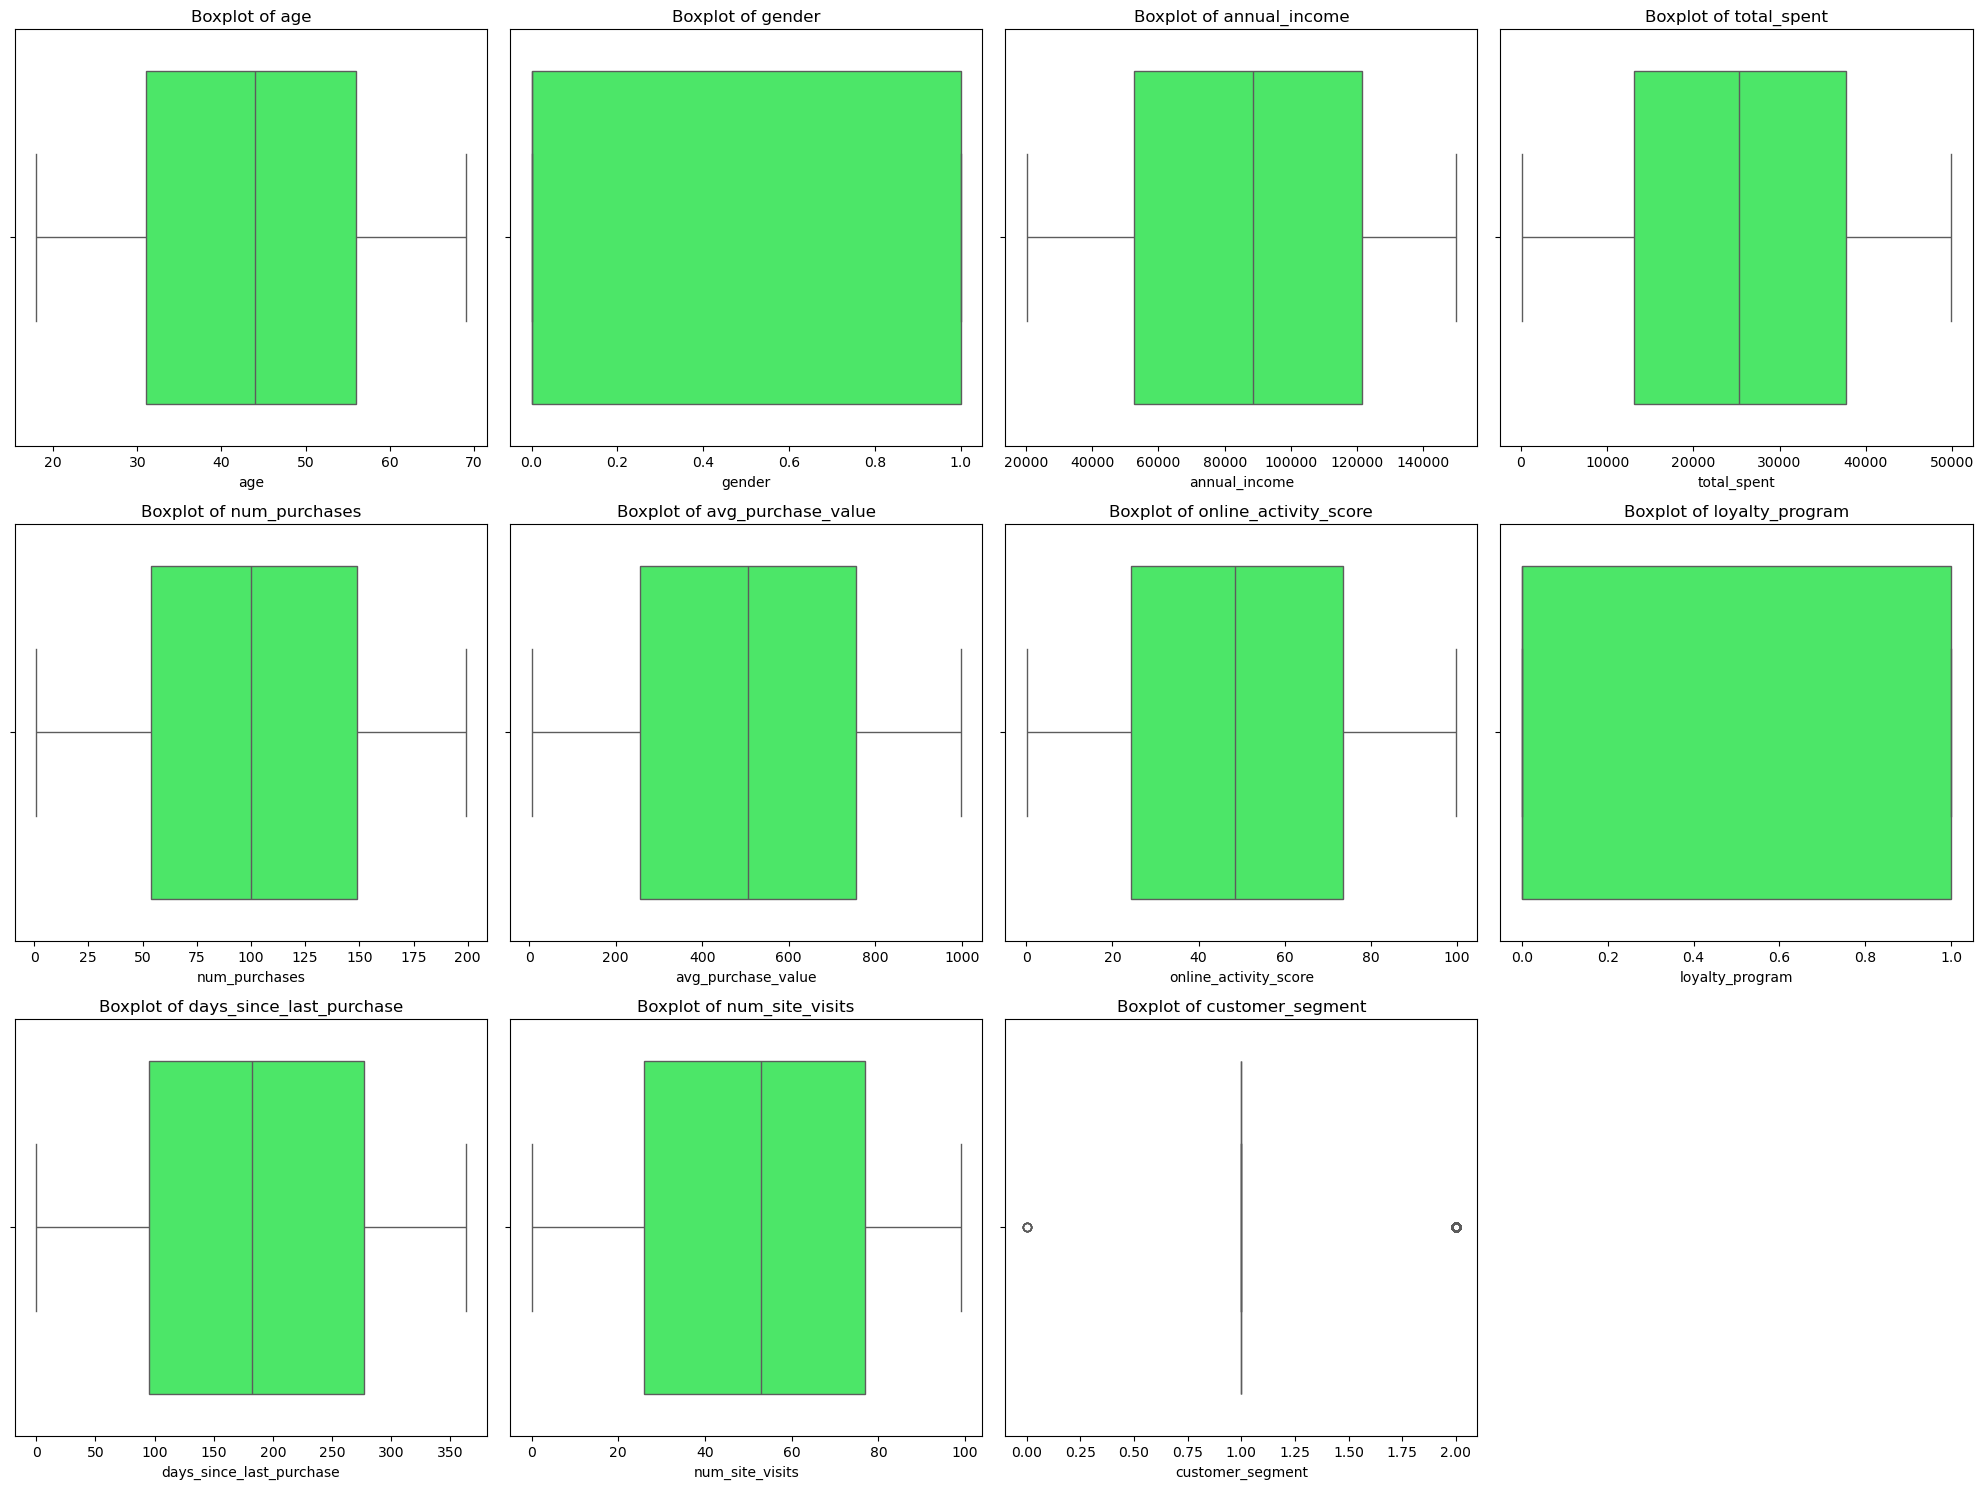

In [12]:
# Filtrar columnas numéricas con al menos dos valores únicos
numeric_cols = [col for col in data.select_dtypes(include=['int', 'float']).columns if data[col].nunique() > 1]

# Configurar el número de filas y columnas
num_cols = 4  # Máximo de gráficos por fila
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

# Crear figura con un subgráfico para cada columna
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

# Aplanar los ejes para iterar fácilmente y esconder los gráficos vacíos
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=data, x=col, ax=axes[i], color="#33FF57")
    axes[i].set_title(f'Boxplot of {col}')
    
# Eliminar cualquier gráfico vacío en la cuadrícula
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 3. Escalado de los Datos

In [13]:
# Normalizar las características numéricas
scaler = StandardScaler()
data[['age', 'annual_income', 'total_spent', 'num_purchases', 'avg_purchase_value', 'online_activity_score',
    'days_since_last_purchase', 'num_site_visits']] = scaler.fit_transform(data[['age', 'annual_income',
    'total_spent', 'num_purchases', 'avg_purchase_value', 'online_activity_score', 'days_since_last_purchase',
    'num_site_visits']])

In [14]:
data.describe() #Obtener las estadísticas descriptivas de las columnas numéricas
#Visualizar la existencia de Outliers

,age,gender,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment
count,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,-1.634248e-16,0.476000,1.048051e-16,-5.062617e-17,4.973799e-17,2.309264e-16,4.263256e-17,0.289000,-9.237056e-17,9.592327e-17,1.130000
std,1.000500e+00,0.499674,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.453525,1.000500e+00,1.000500e+00,0.353872
min,-1.723158e+00,0.000000,-1.746715e+00,-1.732114e+00,-1.762860e+00,-1.733979e+00,-1.716971e+00,0.000000,-1.761541e+00,-1.777414e+00,0.000000
25%,-8.555393e-01,0.000000,-8.980375e-01,-8.339142e-01,-8.195260e-01,-8.578916e-01,-8.625125e-01,0.000000,-8.514117e-01,-8.744857e-01,1.000000
50%,1.207993e-02,0.000000,3.526967e-02,1.722782e-02,-7.831453e-04,1.464792e-02,-2.015594e-02,0.000000,-1.313460e-02,6.317022e-02,1.000000
75%,8.129592e-01,1.000000,8.943481e-01,8.774285e-01,8.713559e-01,8.820597e-01,8.672596e-01,1.000000,8.922047e-01,8.966421e-01,1.000000
max,1.680578e+00,1.000000,1.636694e+00,1.722187e+00,1.761294e+00,1.725767e+00,1.785272e+00,1.000000,1.716111e+00,1.660658e+00,2.000000


# 4. División de Datos en Conjuntos de Entrenamiento y Prueba

In [15]:
# Definir las variables X (características) y y (etiquetas)
X = data.drop(columns=['customer_id', 'customer_segment'])
y = data['customer_segment']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamaño de X_train:", len(X_train))

Tamaño de X_train: 800


In [16]:
# Confirmar que no hay valores NaN en los datos de entrenamiento
print("Valores NaN en X_train:", X_train.isnull().sum().sum())
print("Valores NaN en y_train:", y_train.isnull().sum().sum())

Valores NaN en X_train: 0
Valores NaN en y_train: 0


# 5. Inicialización de SageMaker y Carga de Datos a S3

In [17]:
# Inicialización de sesión de SageMaker
session = sagemaker.Session()

# Guardar los datos en formato LIBSVM
from sklearn.datasets import dump_svmlight_file
dump_svmlight_file(X_train, y_train, "train.libsvm")
dump_svmlight_file(X_test, y_test, "test.libsvm")
print("Archivos train.libsvm y test.libsvm creados.")

# Cargar los archivos a S3
s3_input_train = session.upload_data("train.libsvm", bucket=bucket, key_prefix='customer-classification')
s3_input_validation = session.upload_data("test.libsvm", bucket=bucket, key_prefix='customer-classification')

print(f"Datos cargados a S3:\nTrain: {s3_input_train}\nTest: {s3_input_validation}")

Archivos train.libsvm y test.libsvm creados.
Datos cargados a S3:
Train: s3://sagemaker-test-api-bucket20/customer-classification/train.libsvm
Test: s3://sagemaker-test-api-bucket20/customer-classification/test.libsvm


# 6. Configuración del Estimador de SageMaker para XGBoost


In [18]:
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator

# Crear el Estimador para el modelo XGBoost
xgboost_container = sagemaker.image_uris.retrieve(
    "xgboost",  # Framework
    sagemaker.Session().boto_region_name,  # Región
    version="1.5-1"  # Versión del contenedor
)

xgb = Estimator(
    image_uri=xgboost_container,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",
    volume_size=5,
    max_run=300,
    output_path=f's3://{bucket}/customer-classification/',
    sagemaker_session=session
)

# Configurar hiperparámetros para clasificación multiclase
xgb.set_hyperparameters(
    objective="multi:softmax",
    num_class=3,  
    eta=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    num_round=100
)

# 7. Entrenamiento del Modelo

In [19]:
# Entrenar el modelo XGBoost
modelo = xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-12-04-21-09-31-483


2024-12-04 21:09:35 Starting - Starting the training job...
2024-12-04 21:09:50 Starting - Preparing the instances for training...
2024-12-04 21:10:14 Downloading - Downloading input data...
2024-12-04 21:10:50 Downloading - Downloading the training image......
2024-12-04 21:12:01 Training - Training image download completed. Training in progress.
2024-12-04 21:12:01 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2024-12-04 21:11:57.268 ip-10-2-67-40.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-12-04 21:11:57.293 ip-10-2-67-40.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-12-04:21:11:57:INFO] Imported framework sagemaker_xgboost_container.training
[2024-12-04:21:1

# 8. Guardar el Modelo

In [20]:
# Ruta del archivo en S3
s3_model_path = 's3://sagemaker-test-api-bucket20/customer-classification/sagemaker-xgboost-2024-11-19-00-43-11-928/output/model.tar.gz'

# Ruta local donde deseas guardar el archivo
local_model_path = '/proyecto_dir20/model.tar.gz'

In [21]:
import os

local_model_path = 'proyecto_dir20/model.tar.gz'

# Verificar si el archivo existe
if os.path.exists(local_model_path):
    print(f"El archivo {local_model_path} existe.")
else:
    print(f"El archivo {local_model_path} no existe. Verifica la ruta.")

El archivo proyecto_dir20/model.tar.gz existe.


In [22]:
# Verificar contenido de la carpeta
directory_path = 'proyecto_dir20'
print("Contenido del directorio:", os.listdir(directory_path))

Contenido del directorio: ['.ipynb_checkpoints', 'model.tar.gz', 'extracted_model']


In [23]:
# Verificar si es un archivo
if os.path.isfile(local_model_path):
    print(f"El archivo {local_model_path} es un archivo válido.")
else:
    print(f"El archivo {local_model_path} no es un archivo válido. Es un directorio.")

El archivo proyecto_dir20/model.tar.gz no es un archivo válido. Es un directorio.


In [24]:
import tarfile

# Asegúrate de que la ruta al archivo sea correcta y esté completa
local_model_path = 'proyecto_dir20/model.tar.gz/model.tar.gz'

# Verificar si el archivo existe
if os.path.exists(local_model_path):
    print(f"El archivo {local_model_path} existe.")
    
    # Ruta donde se descomprimirán los archivos
    extracted_model_path = 'proyecto_dir20/extracted_model/model.tar.gz'

    # Descomprimir el archivo tar.gz
    with tarfile.open(local_model_path, 'r:gz') as tar:
        tar.extractall(path=extracted_model_path)
    
    print(f"Archivos descomprimidos en: {extracted_model_path}")
else:
    print(f"El archivo {local_model_path} no existe. Verifica la ruta.")


El archivo proyecto_dir20/model.tar.gz/model.tar.gz existe.
Archivos descomprimidos en: proyecto_dir20/extracted_model/model.tar.gz


# 9. Desplegar el Modelo en SageMaker

In [25]:
# Desplegar el modelo entrenado para realizar predicciones
predictor = xgb.deploy(initial_instance_count=1, instance_type="ml.t2.medium")


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-12-04-21-12-58-626
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-12-04-21-12-58-626
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-12-04-21-12-58-626


----------------!

In [26]:
# Realizar predicciones en el conjunto de prueba
with open("test.libsvm", "r") as file:
    payload = file.read()
y_pred = predictor.predict(payload, initial_args={"ContentType": "text/libsvm"})

# 10. Evaluación del Modelo

In [27]:
print(len(y_test), len(y_pred))

200 800


In [28]:
y_pred = y_pred[:len(y_test)]


In [29]:
print(len(y_test), len(y_pred))

200 200


In [30]:
# Si las predicciones son probabilidades (en clasificación binaria), convierte a clases
y_pred = np.array([1 if float(p) > 0.5 else 0 for p in y_pred])

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.86
Precision: 0.7395999999999999
Recall: 0.86
F1-score: 0.795268817204301


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 11. Obtener el Nombre del Endpoint

In [31]:
# Nombre del endpoint
print(f'Endpoint name: {predictor.endpoint}')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: sagemaker-xgboost-2024-12-04-21-12-58-626


# 12. Eliminar monitor

In [32]:

import subprocess
import json

# Ejecuta el comando AWS CLI para listar los cronogramas de monitoreo
command = "aws sagemaker list-monitoring-schedules"
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Imprime el resultado
if result.returncode == 0:
    # Si el comando se ejecutó correctamente, parsea el JSON y lo muestra
    monitoring_schedules = json.loads(result.stdout)
    print(json.dumps(monitoring_schedules, indent=2))
else:
    # Si hubo un error al ejecutar el comando, muestra el mensaje de error
    print(f"Error: {result.stderr}")

{
  "MonitoringScheduleSummaries": []
}


In [33]:

import subprocess

# Nombre del cronograma de monitoreo
monitor_name = "hora-data-quality-monitor20"

# Comando para detener el cronograma de monitoreo
command = f"aws sagemaker stop-monitoring-schedule --monitoring-schedule-name {monitor_name}"

# Ejecuta el comando
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Verifica si el comando fue exitoso
if result.returncode == 0:
    print(f"Monitoreo '{monitor_name}' detenido correctamente.")
else:
    print(f"Error al detener el monitoreo: {result.stderr}")

Error al detener el monitoreo: 
An error occurred (ResourceNotFound) when calling the StopMonitoringSchedule operation: Monitoring Schedule arn:aws:sagemaker:us-east-1:569548748090:monitoring-schedule/hora-data-quality-monitor20 not found



In [35]:
'''
import boto3

# Inicializa el cliente de SageMaker
sagemaker_client = boto3.client('sagemaker')

# Nombre del monitoreo que deseas eliminar
monitoring_schedule_name = 'hora-data-quality-monitor20'

# Eliminar el monitoreo
response = sagemaker_client.delete_monitoring_schedule(
    MonitoringScheduleName=monitoring_schedule_name
)

# Imprimir la respuesta
print("Monitoreo eliminado:", response)'''

'\nimport boto3\n\n# Inicializa el cliente de SageMaker\nsagemaker_client = boto3.client(\'sagemaker\')\n\n# Nombre del monitoreo que deseas eliminar\nmonitoring_schedule_name = \'hora-data-quality-monitor20\'\n\n# Eliminar el monitoreo\nresponse = sagemaker_client.delete_monitoring_schedule(\n    MonitoringScheduleName=monitoring_schedule_name\n)\n\n# Imprimir la respuesta\nprint("Monitoreo eliminado:", response)'

In [ ]:
#predictor.delete_endpoint()